In [19]:
from tdc.single_pred import Epitope
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score, precision_recall_curve
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score, precision_score, recall_score, accuracy_score
from copy import deepcopy
torch.manual_seed(1)
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt  
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_auc_score 
from tdc.multi_pred import AntibodyAff
from collections import defaultdict

In [6]:
# data = AntibodyAff(name = 'Protein_SAbDab')
# split = data.get_split()

Found local copy...
Loading...
Done!


In [80]:
data =  Epitope(name = 'IEDB_Jespersen')
split = data.get_split()

Found local copy...
Loading...
Done!


In [81]:
train_data = split['train']
valid_data = split['valid']
test_data = split['test']

In [92]:
type(train_data['Y'][0])

list

In [41]:
train = train_data.to_dict("records")

In [42]:
train

[{'Antigen_ID': 'Protein 2',
  'Antigen': 'MSDLTDIQEDITRHEQQLIVARQKLKDAERAVEVDPDDVNKNTLQARQQTVSALEDKLADYKRRMADAVSRKKMDTKPTDPTGIEPDDHLKERSSLRYGNVLDVNAIDIEEPSGQTADWYTIGVYVIGFTLPIILKALYMLSTRGRQTVKENKGTRIRFKDDTSFEDINGIRRPKHLYVSMPTAQSTMKAEELTPGRFRTIVCGLFPTQIQVRNIMSPVMGVIGFSFFVKDWSERIREFMEKECPFIKPEVKPGTPAQEIEMLKRNKIYFMQRQDVLDKNHVADIDKLIDYAASGDPTSPDNIDSPNAPWVFACAPDRCPPTCIYVAGMAELGAFFSILQDMRNTIMASKTVGTAEEKLKKKSSFYQSYLRRTQSMGIQLDQRIILLFMLEWGKEMVDHFHLGDDMDPELRGLAQALIDQKVKEISNQEPLKI',
  'Y': [312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325]},
 {'Antigen_ID': 'Protein 3',
  'Antigen': 'MAEGFAANRQWIGPEEAEELLDFDIAIQMNEEGPLNPGVNPFRVPGITEAEKQEYCNILQPKLQDLKGKIQEVKLEEGNAGKFRRARFLRYSDETVLSLIHLFIGYCPHLCRRHELGSLRHDIDIEALQEERYNDREKGITDNIKYGKRCLIGTAVLYLLLSLGIIIHTCKAQVVWRLPPLVVPVEESEIIFWDCWAPEEPACQDFLGAMIHLKASTNISIQEGPTLGNWAREIWGTLFKKATRQCRRGRIWRRWNETITGPLGCANNTCYNISVIVPDYQCYLDRVDTWLQGKVNISLCLTGGKMLYNKETKQLSYCTDPLQIPLINYTFGPNQTCMWNTSQIQDPEIPKCGWWNQNAYYNSCRWEHTDVQFQCQRTQSQPGSWIRAISSWKQRNRW

In [58]:
def to_protlists(data):

    protlists = list()
    temp_dict = data.to_dict("records")
    for record in temp_dict:
        protlist = defaultdict(list)
        antigen = record['Antigen_ID']
        seq = record['Antigen']
        desc = ''
        protlist[antigen].append(desc)
        protlist[antigen].append(seq)

        protlists.append(protlist)
        
    return protlists

In [59]:
train_dict = to_protlists(train_data)

In [62]:
lst = train_dict[0]

In [83]:
X = 'Antigen'

In [84]:
def data2vocab(data):
	length = len(data)
	vocab_set = set()
	total_length, positive_num = 0, 0
	for i in range(length):
		antigen = data[X][i]
		vocab_set = vocab_set.union(set(antigen))
		Y = data['Y'][i]
		assert len(antigen) > max(Y)
		total_length += len(antigen)
		positive_num += len(Y)
	return vocab_set, positive_num / total_length

In [85]:
train_vocab, train_positive_ratio = data2vocab(train_data)
valid_vocab, valid_positive_ratio = data2vocab(valid_data)
test_vocab, test_positive_ratio = data2vocab(test_data)

In [86]:
vocab_set = train_vocab.union(valid_vocab)
vocab_set = vocab_set.union(test_vocab)
vocab_lst = list(vocab_set)
# logger

In [88]:
len(vocab_lst)

24

In [89]:
vocab_lst

['X',
 'Q',
 'S',
 'N',
 'Y',
 'C',
 'W',
 'L',
 'Z',
 'G',
 'H',
 'J',
 'F',
 'K',
 'P',
 'T',
 'E',
 'M',
 'V',
 'R',
 'D',
 'A',
 'B',
 'I']

In [72]:
lst.keys()[0]

TypeError: 'dict_keys' object is not subscriptable

In [32]:
def onehot(idx, length):
	lst = [0 for i in range(length)]
	lst[idx] = 1
	return lst 

def zerohot(length):
	return [0 for i in range(length)]

# what is the maxlength here
def standardize_data(data, vocab_lst, maxlength = 300):
	length = len(data)
	standard_data = []
	for i in range(length):
		antigen = data[X][i]
		Y = data['Y'][i] 
		sequence = [onehot(vocab_lst.index(s), len(vocab_lst)) for s in antigen] 
		labels = [0 for i in range(len(antigen))]
		mask = [True for i in range(len(labels))] # labels and mask have the same length
		sequence += (maxlength-len(sequence)) * [zerohot(len(vocab_lst))] #pad to consistent length
		labels += (maxlength-len(labels)) * [0] 
		mask += (maxlength-len(mask)) * [False] # pad to maxlength
		for y in Y:
			labels[y] = 1 		
		sequence, labels, mask = sequence[:maxlength], labels[:maxlength], mask[:maxlength]
		sequence, labels, mask = torch.FloatTensor(sequence), torch.FloatTensor(labels), torch.BoolTensor(mask) 
		# print(sequence.shape, labels.shape, mask.shape)
        # sequence is 2D, labels and mask are 1D
		standard_data.append((sequence, labels, mask))
	return standard_data 

In [33]:
train_data_stand = standardize_data(train_data, vocab_lst)
valid_data_stand = standardize_data(valid_data, vocab_lst)
test_data_stand = standardize_data(test_data, vocab_lst)

In [57]:
class dataset(Dataset):
	def __init__(self, data):
		self.sequences = [i[0] for i in data]
		self.labels = [i[1] for i in data]
		self.mask = [i[2] for i in data] 

	def __getitem__(self, index):
		return self.sequences[index], self.labels[index], self.mask[index]

	def __len__(self):
		return len(self.labels)

In [58]:
train_set = dataset(train_data_stand)
valid_set = dataset(valid_data_stand)
test_set = dataset(test_data_stand)
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)

In [62]:
def plot(label_lst, predict_lst, name):

    fpr, tpr, thresholds = metrics.roc_curve(label_lst, predict_lst, )
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.savefig(name)

In [63]:
class RNN(nn.Module):
    def __init__(self, name, hidden_size, input_size, num_layers = 2):
        super(RNN, self).__init__()
        self.name = name 
        self.hidden_size = hidden_size
        self.input_size = input_size 
        self.rnn = nn.LSTM(         # if use nn.RNN(), it hardly learns
            input_size=input_size,
            hidden_size=hidden_size,         # rnn hidden unit
            num_layers=num_layers,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        self.out = nn.Linear(hidden_size, 1)
        criterion = torch.nn.BCEWithLogitsLoss()  
        self.opt = torch.optim.Adam(self.parameters(), lr=1e-3)
    
    
    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out)
        out = out.squeeze(-1)
        return out
    
    def learn(self, sequence, labels, mask):
        prediction = self.forward(sequence)
        # print("size", prediction.shape, labels.shape, mask.shape)
        criterion = torch.nn.BCEWithLogitsLoss(size_average=True, weight = mask)  
        loss = criterion(prediction, labels)
        self.opt.zero_grad() 
        loss.backward() 
        self.opt.step()
        
    def test(self, test_loader, name):
        label_lst, prediction_lst = [], []
        for sequence, labels, mask in test_loader:
            prediction = self.forward(sequence)
            prediction = torch.sigmoid(prediction)
            for pred, label, msk in zip(prediction, labels, mask):
                num = sum(msk.tolist()) 
                pred = pred.tolist()[:num] 
                label = label.tolist()[:num] 
                label_lst.extend(label)
                prediction_lst.extend(pred)
        sort_pred = deepcopy(prediction_lst)
        sort_pred.sort() 
        threshold = sort_pred[int(len(sort_pred)*0.9)]
        float2binary = lambda x:0 if x<threshold else 1
        binary_pred_lst = list(map(float2binary, prediction_lst))
        plot(label_lst, prediction_lst, name)
        print('roc_auc', roc_auc_score(label_lst, prediction_lst), 
    		  'F1', f1_score(label_lst, binary_pred_lst), 
    		  'prauc', average_precision_score(label_lst, binary_pred_lst))
        

roc_auc 0.5244758116334255 F1 0.06485664445140224 prauc 0.04172405459172531
roc_auc 0.5280550711615168 F1 0.06200509998657899 prauc 0.04148809601373876
roc_auc 0.5224101741465251 F1 0.06371364653243848 prauc 0.04162749848003265
roc_auc 0.5330005779725382 F1 0.06809843400447428 prauc 0.04201701102195229
roc_auc 0.5362415936262406 F1 0.07104191831074129 prauc 0.04230438941592866
roc_auc 0.5387150991989351 F1 0.0718536083396716 prauc 0.04238750501966124
roc_auc 0.5433478645937785 F1 0.07293064876957495 prauc 0.04250014445884075
roc_auc 0.555926477139887 F1 0.07686800894854585 prauc 0.04293557569160582
roc_auc 0.5626654142050868 F1 0.0796420581655481 prauc 0.043264877232858226
roc_auc 0.5677640236613388 F1 0.08313199105145413 prauc 0.0437056031787577


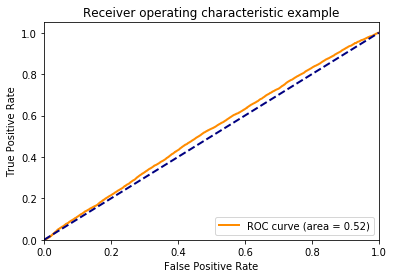

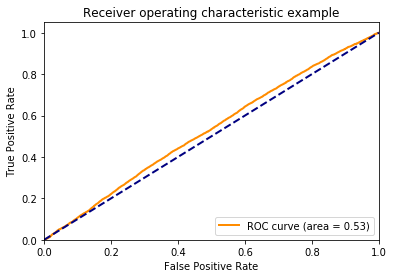

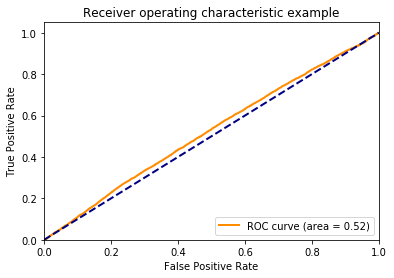

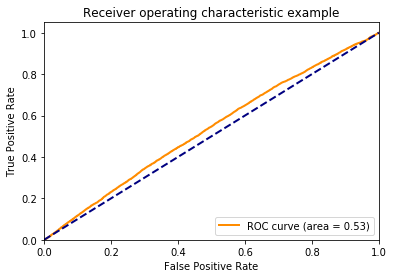

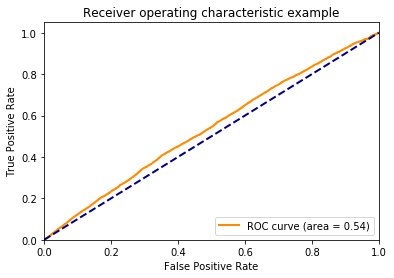

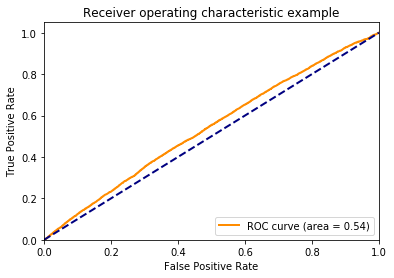

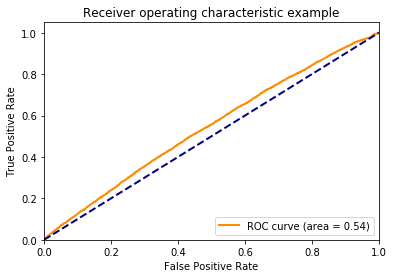

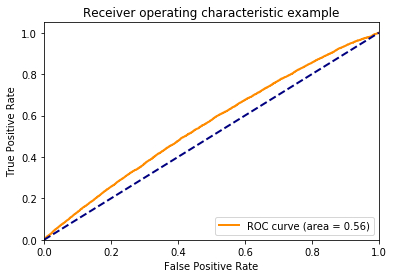

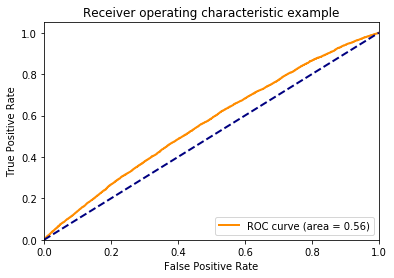

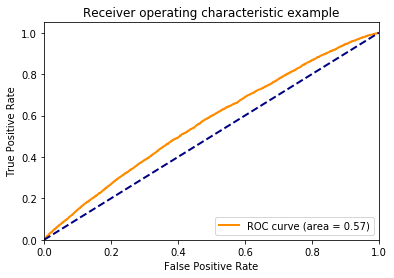

In [64]:
model = RNN(name = 'Epitope', hidden_size=100, input_size=len(vocab_lst))
epoch = 10
for ep in range(epoch):
    for sequence, labels, mask in train_loader:
        model.learn(sequence, labels, mask)
    model.test(test_loader, name = model.name + '_' + str(ep) + '.png')